# **Анализ данных: рекламные кампании в недвижимости**

**Дано:** статистика по рекламным кампаниям двух жилых комплексов (ЖК "Синица" и ЖК "Ласточка") Санкт-Петербурга в 3 каналах (Директ, AdWords, Facebook) за полгода; статистика по обращениям из двух источников (звонки из системы Comagic и заявки на обратный звонок из системы Envybox) + данные по лидам из самого Facebook.

**Задача:** выяснить, есть ли взаимосвязь между стоимостью лида и днем недели в каждом из каналов по ЖК и по каналам в целом.

**Термины и определения**:
- Campaign: рекламная кампания. Как правило, в одном источнике - несколько рекламных кампаний, поэтому для посчета итоговых значений они будут объединены.
- Shows: показы по рекламной кампании. Не являются для нас целевой переменной.
- Clicks: переходы по рекламной кампании. Не являются для нас целевой переменной.
- CTR: отношение кликов к показам, умноженное на 100%. Характеризует привлекательность рекламного объявления. Не является для нас целевой переменной.
- Spent: расход по рекламной кампании за определенную дату. Равен произведению числа кликов на среднюю стоимость клика. В нашем анализе будет сгруппирован по всем рекламным кампаниям в источнике, а затем по всем рекламным кампаниям в источнике и по дням недели.
- CPC (cost per click): средняя стоимость клика. Не является для нас целевой переменной.
- CPA (cost per action): стоимость целевого действия (звонка или заявки). Равна отношению расхода к количеству целевых действий.
- Лид: действие, которое принято рекламодателем за целевое. В нашем случае - заявка и звонок.

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")

Загружаем данные. Статистику по расходу получаем из 3 систем, статистику по обращениям - из двух.

In [2]:
Lasto4kaD = pd.read_csv('Lasto4ka Direct.csv', sep=';', decimal=',', parse_dates=[2], dayfirst=True)
SinitzaA = pd.read_csv('Sinitza AdWords.csv', sep=';', decimal=',', parse_dates=[1], dayfirst=True)
Lasto4kaA = pd.read_csv('Lasto4ka AdWords.csv', sep=';', decimal=',', parse_dates=[1], dayfirst=True)
SinitzaD = pd.read_csv('Sinitza Direct.csv', sep=';', decimal=',', parse_dates=[2], dayfirst=True)
Lasto4kaF = pd.read_csv('Lasto4ka Facebook.csv', sep=';', decimal=',', parse_dates=[1], dayfirst=True)
SinitzaF = pd.read_csv('Sinitza Facebook.csv', sep=';', decimal=',', parse_dates=[1], dayfirst=True)
Comagic = pd.read_csv('Comagic.csv', sep=';', decimal=',', parse_dates=[0], dayfirst=True)
Envybox = pd.read_csv('Envybox.csv', sep=';', decimal=',', parse_dates=[0], dayfirst=True)

In [4]:
SinitzaD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Campaign     1842 non-null   object        
 1   ID Campagin  1842 non-null   int64         
 2   Date         1842 non-null   datetime64[ns]
 3   Shows        1842 non-null   int64         
 4   Clicks       1842 non-null   int64         
 5   CTR          1842 non-null   float64       
 6   Spent        1842 non-null   float64       
 7   CPC          1842 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 115.2+ KB


Оставляем в наших данных по расходу только интересующие нас: дата и расход за эту дату.

In [5]:
SinitzaD = pd.DataFrame(SinitzaD.groupby('Date')['Spent'].sum()).reset_index()
Lasto4kaD = pd.DataFrame(Lasto4kaD.groupby('Date')['Spent'].sum()).reset_index()
SinitzaA = pd.DataFrame(SinitzaA.groupby('Date')['Spent'].sum()).reset_index()
Lasto4kaA = pd.DataFrame(Lasto4kaA.groupby('Date')['Spent'].sum()).reset_index()
Lasto4kaFb = pd.DataFrame(Lasto4kaF.groupby('Date')['Spent'].sum()).reset_index()
SinitzaFb = pd.DataFrame(SinitzaF.groupby('Date')['Spent'].sum()).reset_index()

В наших данных есть ньюансы. В Директе мы скачиваем расход с НДС. В AdWords без НДС. В Facebook без НДС и комиссии за перевод. Сделаем все единообразно.

In [6]:
SinitzaA['Spent'] = SinitzaA['Spent'].multiply(1.2)
Lasto4kaA['Spent'] = Lasto4kaA['Spent'].multiply(1.2)
SinitzaFb['Spent'] = SinitzaFb['Spent'].multiply(1.2)
Lasto4kaFb['Spent'] = Lasto4kaFb['Spent'].multiply(1.2)
SinitzaFb['Spent'] = SinitzaFb['Spent'].div(0.93)
Lasto4kaFb['Spent'] = Lasto4kaFb['Spent'].div(0.93)

Также нужно обработать данные по лидам. В каждом из файлов есть информация по обоим объектам, но только по двум каналам (Директ и AdWords). Лиды по Facebook нужно извлечь из файла с расходом. 

In [7]:
Comagic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      884 non-null    datetime64[ns]
 1   Time      884 non-null    object        
 2   Number    884 non-null    int64         
 3    Source   884 non-null    object        
 4   Medium    884 non-null    object        
 5   Campaign  883 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 41.6+ KB


В столбце "Time" отображается длительность разговора. В столбце "Number" - номер обращения. В статистике для анализа изначально выгружены только первичные обращения (везде единичка), поэтому мы можем использовать этот столбец для подсчета их количества. В столбце "Source"  в нашем случае отображается объект, у нас их два - ЖК "Синица" и ЖК "Ласточка". В столбце "Medium" - источник (или Яндекс = Директ, или Google = AdWords).

In [8]:
Comagic['Number'].nunique()

1

Данные в Envybox похожи. Нам только придется добавить аналогичную колонку "Number", в обеих системах отбросить часть данных и переименовать "UTM_SOURCE" в "Object", что в данном случае корректно.

In [9]:
Envybox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2465 non-null   datetime64[ns]
 1   Time          2209 non-null   object        
 2   UTM_SOURCE    2465 non-null   object        
 3   UTM_MEDIUM    2465 non-null   object        
 4   UTM_CAMPAIGN  2464 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 96.4+ KB


In [10]:
Envybox['Number'] = 1
Envybox['Date'] = pd.to_datetime(Envybox['Date']).dt.date
Envybox.rename(columns={'UTM_SOURCE': 'Object', 'UTM_MEDIUM': 'Medium'}, inplace=True)
Comagic.rename(columns={' Source': 'Object'}, inplace=True)
Comagic['Date'] = pd.to_datetime(Comagic['Date']).dt.date

Разбиваем данные в каждом файле по объектам, а затем группируем данные по каждому объекту.

In [11]:
Sinitza = Envybox[(Envybox['Object'] == 'moskovsky')]
Sinitza1 = Comagic[(Comagic['Object'] == 'moskovsky')]
Sinitza = Sinitza.append(Sinitza1)
Sinitza.drop(['UTM_CAMPAIGN', 'Campaign'], axis='columns', inplace=True)

В полученном файле выделяем лиды по Директу и AdWords, группируем их с информацией по расходу. Аналогично данные по лидам из статистики по Facebook объединяем с данными по расходу в Facebook.


In [12]:
SinitzaDL = Sinitza[(Sinitza['Medium'] == 'yandex')]
SinitzaAL = Sinitza[(Sinitza['Medium'] == 'google')]
SinitzaDL = pd.DataFrame(SinitzaDL.groupby('Date')['Number'].sum()).reset_index()
SinitzaAL = pd.DataFrame(SinitzaAL.groupby('Date')['Number'].sum()).reset_index()
SinitzaFbL = pd.DataFrame(SinitzaF.groupby('Date')['Leads'].sum()).reset_index()
SinitzaFbL.rename(columns={'Leads': 'Number'}, inplace=True)
SinitzaDL['Date'] = pd.to_datetime(SinitzaDL['Date'])
SinitzaAL['Date'] = pd.to_datetime(SinitzaAL['Date'])
SinitzaFbL['Date'] = pd.to_datetime(SinitzaFbL['Date'])
SinitzaD = SinitzaD.merge(SinitzaDL, on='Date')
SinitzaA = SinitzaA.merge(SinitzaAL, on='Date')
SinitzaFb = SinitzaFb.merge(SinitzaFbL, on='Date')

In [13]:
Lasto4ka = Envybox[(Envybox['Object'] == 'pushkinsky')]
Lasto4ka1 = Comagic[(Comagic['Object'] == 'pushkinsky')]
Lasto4ka = Lasto4ka.append(Sinitza1)
Lasto4ka.drop(['UTM_CAMPAIGN', 'Campaign'], axis='columns', inplace=True)
Lasto4kaDL = Lasto4ka[(Lasto4ka['Medium'] == 'yandex')]
Lasto4kaAL = Lasto4ka[(Lasto4ka['Medium'] == 'google')]
Lasto4kaDL = pd.DataFrame(Lasto4kaDL.groupby('Date')['Number'].sum()).reset_index()
Lasto4kaAL = pd.DataFrame(Lasto4kaAL.groupby('Date')['Number'].sum()).reset_index()
Lasto4kaFbL = pd.DataFrame(Lasto4kaF.groupby('Date')['Leads'].sum()).reset_index()#count()#std()
Lasto4kaFbL.rename(columns={'Leads': 'Number'}, inplace=True)
Lasto4kaDL['Date'] = pd.to_datetime(Lasto4kaDL['Date'])
Lasto4kaAL['Date'] = pd.to_datetime(Lasto4kaAL['Date'])
Lasto4kaFbL['Date'] = pd.to_datetime(Lasto4kaFbL['Date'])
Lasto4kaD = Lasto4kaD.merge(Lasto4kaDL, on='Date')
Lasto4kaA = Lasto4kaA.merge(Lasto4kaAL, on='Date')
Lasto4kaFb = Lasto4kaFb.merge(Lasto4kaFbL, on='Date')

Посчитаем CPA за каждый день, объединим данные и добавим дни недели. Кроме этого, нужно проверить, есть ли в наших данных дни, когда лидов не было (значение "Number" - 0). В таком случае при расчете CPA мы получим ошибку (CPA = Spent / Number). Присвоим такой ситуации нулевое CPA, а затем заменим его средним значением.

In [14]:
SinitzaD['Source'] = 'yandex'
SinitzaA['Source'] = 'google'
SinitzaFb['Source'] = 'facebook'
SinitzaD['CPA'] = SinitzaD.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
SinitzaA['CPA'] = SinitzaA.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
SinitzaFb['CPA'] = SinitzaFb.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
Sinitza = SinitzaD.append(SinitzaA)
Sinitza = Sinitza.append(SinitzaFb)

In [15]:
SinitzaFb['CPA'] = np.where(SinitzaFb['CPA'] == 0, SinitzaFb['CPA'].mean(), SinitzaFb['CPA'])

In [16]:
Sinitza = SinitzaD.append(SinitzaA)
Sinitza = Sinitza.append(SinitzaFb)

In [17]:
Sinitza['DayOfWeek'] = Sinitza['Date'].dt.dayofweek

In [18]:
Sinitza

,Date,Spent,Number,Source,CPA,DayOfWeek
0,2020-03-04,9843.590000,1.0,yandex,9843.590000,2
1,2020-03-05,23706.000000,4.0,yandex,5926.500000,3
2,2020-03-06,19206.390000,9.0,yandex,2134.043333,4
3,2020-03-07,16728.560000,4.0,yandex,4182.140000,5
4,2020-03-08,14868.330000,1.0,yandex,14868.330000,6
...,...,...,...,...,...,...
175,2020-08-27,16989.264516,10.0,facebook,1698.926452,3
176,2020-08-28,17069.677419,5.0,facebook,3413.935484,4
177,2020-08-29,17288.425806,3.0,facebook,5762.808602,5
178,2020-08-30,16493.032258,7.0,facebook,2356.147465,6


In [19]:
Lasto4kaD['CPA'] = Lasto4kaD.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
Lasto4kaA['CPA'] = Lasto4kaA.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
Lasto4kaFb['CPA'] = Lasto4kaFb.apply(lambda  row:
                                       row['Spent'] / row['Number'] if row['Number'] !=0 else 0, axis=1)
Lasto4kaD['Source'] =  'yandex'
Lasto4kaA['Source'] =  'google'
Lasto4kaFb['Source'] = 'facebook'
Lasto4ka = Lasto4kaD.append(Lasto4kaA)
Lasto4ka = Lasto4ka.append(Lasto4kaFb)
Lasto4ka['DayOfWeek'] = Lasto4ka['Date'].dt.dayofweek

In [20]:
Lasto4ka

,Date,Spent,Number,CPA,Source,DayOfWeek
0,2020-03-01,19303.970000,3.0,6434.656667,yandex,6
1,2020-03-02,19618.380000,2.0,9809.190000,yandex,0
2,2020-03-03,9604.420000,2.0,4802.210000,yandex,1
3,2020-03-04,31973.390000,5.0,6394.678000,yandex,2
4,2020-03-05,36037.590000,5.0,7207.518000,yandex,3
...,...,...,...,...,...,...
175,2020-08-27,17944.219355,9.0,1993.802151,facebook,3
176,2020-08-28,17924.554839,8.0,2240.569355,facebook,4
177,2020-08-29,19675.612903,7.0,2810.801843,facebook,5
178,2020-08-30,17908.090323,12.0,1492.340860,facebook,6


Посмотрим на наши данные:

[Text(0, 0.5, 'Обращения'),
 Text(0.5, 0, 'Период'),
 Text(0.5, 1.0, 'ЖК "Синица": лиды по каналам')]

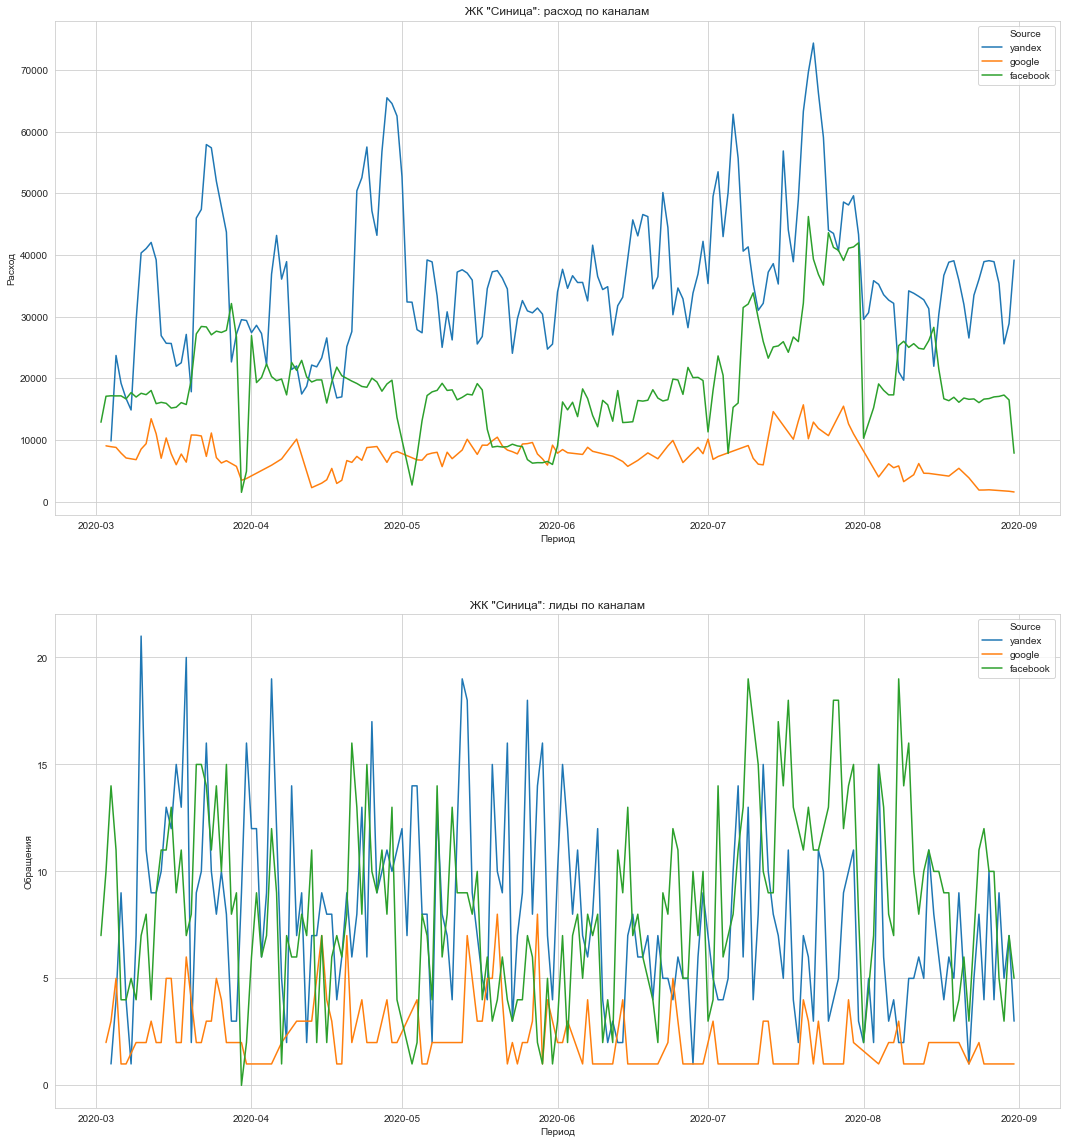

In [21]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18,20)
sns.lineplot(x='Date', y='Spent',hue='Source', data=Sinitza, ax=ax1)
ax1.set(xlabel='Период', ylabel='Расход',title='ЖК "Синица": расход по каналам')
sns.lineplot(x='Date', y='Number',hue='Source', data=Sinitza, ax=ax2)
ax2.set(xlabel='Период', ylabel='Обращения',title='ЖК "Синица": лиды по каналам')

[Text(0, 0.5, 'Обращения'),
 Text(0.5, 0, 'Период'),
 Text(0.5, 1.0, 'ЖК "Ласточка": лиды по каналам')]

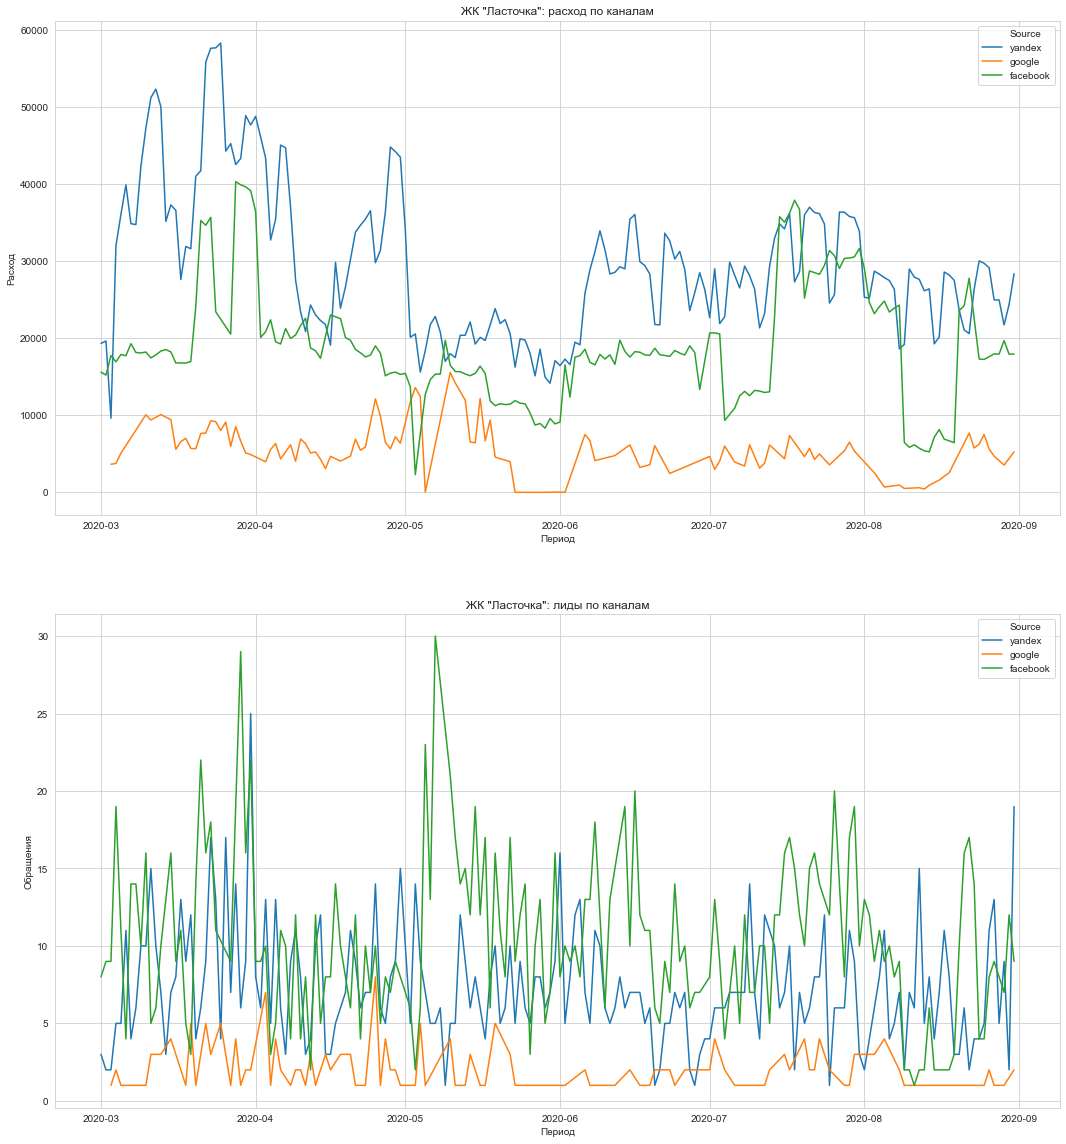

In [22]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18,20)
sns.lineplot(x='Date', y='Spent',hue='Source', data=Lasto4ka, ax=ax1)
ax1.set(xlabel='Период', ylabel='Расход',title='ЖК "Ласточка": расход по каналам')
sns.lineplot(x='Date', y='Number',hue='Source', data=Lasto4ka, ax=ax2)
ax2.set(xlabel='Период', ylabel='Обращения',title='ЖК "Ласточка": лиды по каналам')

Теперь выведем расход, лиды и CPA по дням недели.

In [23]:
SinitzaD['DayOfWeek'] = SinitzaD['Date'].dt.dayofweek
SinitzaA['DayOfWeek'] = SinitzaA['Date'].dt.dayofweek
SinitzaFb['DayOfWeek'] = SinitzaFb['Date'].dt.dayofweek
SinitzaDL['DayOfWeek'] = SinitzaDL['Date'].dt.dayofweek
SinitzaAL['DayOfWeek'] = SinitzaAL['Date'].dt.dayofweek
SinitzaFbL['DayOfWeek'] = SinitzaFbL['Date'].dt.dayofweek

[Text(0, 0.5, 'Обращения'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Лиды по Facebook по дням недели')]

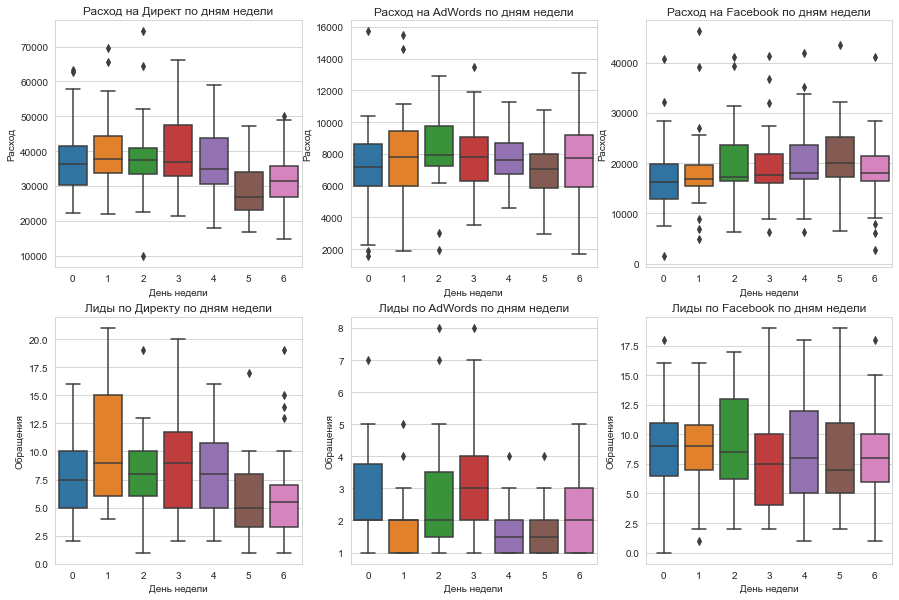

In [24]:
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(15, 10)
sns.boxplot(data=SinitzaD, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][0])
sns.boxplot(data=SinitzaA, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][1])
sns.boxplot(data=SinitzaFb, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][2])
sns.boxplot(data=SinitzaDL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][0])
sns.boxplot(data=SinitzaAL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][1])
sns.boxplot(data=SinitzaFbL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][2])
axes[0][0].set(xlabel='День недели', ylabel='Расход',title="Расход на Директ по дням недели")
axes[0][1].set(xlabel='День недели', ylabel='Расход',title="Расход на AdWords по дням недели")
axes[0][2].set(xlabel='День недели', ylabel='Расход',title="Расход на Facebook по дням недели")
axes[1][0].set(xlabel='День недели', ylabel='Обращения',title="Лиды по Директу по дням недели")
axes[1][1].set(xlabel='День недели', ylabel='Обращения',title="Лиды по AdWords по дням недели")
axes[1][2].set(xlabel='День недели', ylabel='Обращения',title="Лиды по Facebook по дням недели")

In [25]:
Lasto4kaD['DayOfWeek'] = Lasto4kaD['Date'].dt.dayofweek
Lasto4kaA['DayOfWeek'] = Lasto4kaA['Date'].dt.dayofweek
Lasto4kaFb['DayOfWeek'] = Lasto4kaFb['Date'].dt.dayofweek
Lasto4kaDL['DayOfWeek'] = Lasto4kaDL['Date'].dt.dayofweek
Lasto4kaAL['DayOfWeek'] = Lasto4kaAL['Date'].dt.dayofweek
Lasto4kaFbL['DayOfWeek'] = Lasto4kaFbL['Date'].dt.dayofweek

[Text(0, 0.5, 'Обращения'),
 Text(0.5, 0, 'День недели'),
 Text(0.5, 1.0, 'Лиды по Facebook по дням недели')]

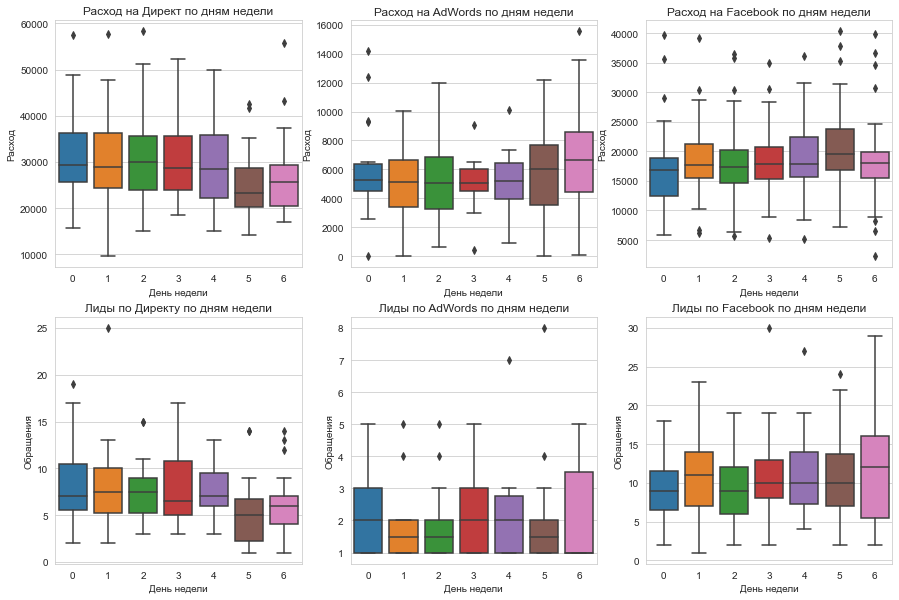

In [26]:
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(15, 10)
sns.boxplot(data=Lasto4kaD, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][0])
sns.boxplot(data=Lasto4kaA, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][1])
sns.boxplot(data=Lasto4kaFb, y='Spent', x='DayOfWeek', orient="v",ax=axes[0][2])
sns.boxplot(data=Lasto4kaDL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][0])
sns.boxplot(data=Lasto4kaAL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][1])
sns.boxplot(data=Lasto4kaFbL, y='Number', x='DayOfWeek', orient="v",ax=axes[1][2])
axes[0][0].set(xlabel='День недели', ylabel='Расход',title="Расход на Директ по дням недели")
axes[0][1].set(xlabel='День недели', ylabel='Расход',title="Расход на AdWords по дням недели")
axes[0][2].set(xlabel='День недели', ylabel='Расход',title="Расход на Facebook по дням недели")
axes[1][0].set(xlabel='День недели', ylabel='Обращения',title="Лиды по Директу по дням недели")
axes[1][1].set(xlabel='День недели', ylabel='Обращения',title="Лиды по AdWords по дням недели")
axes[1][2].set(xlabel='День недели', ylabel='Обращения',title="Лиды по Facebook по дням недели")

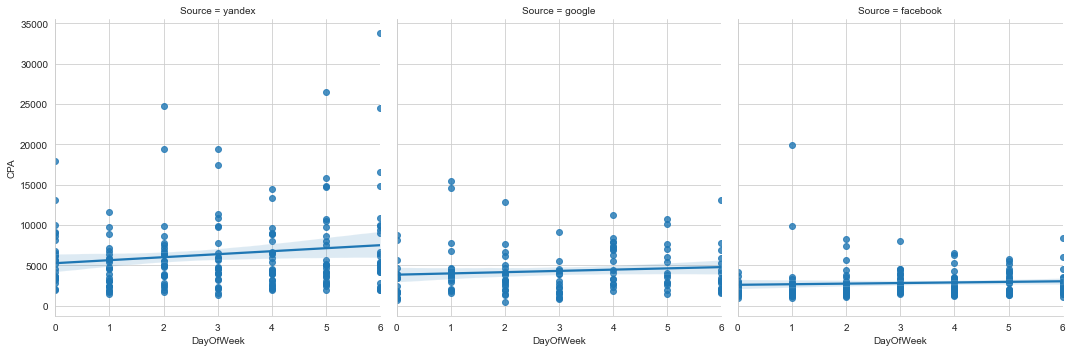

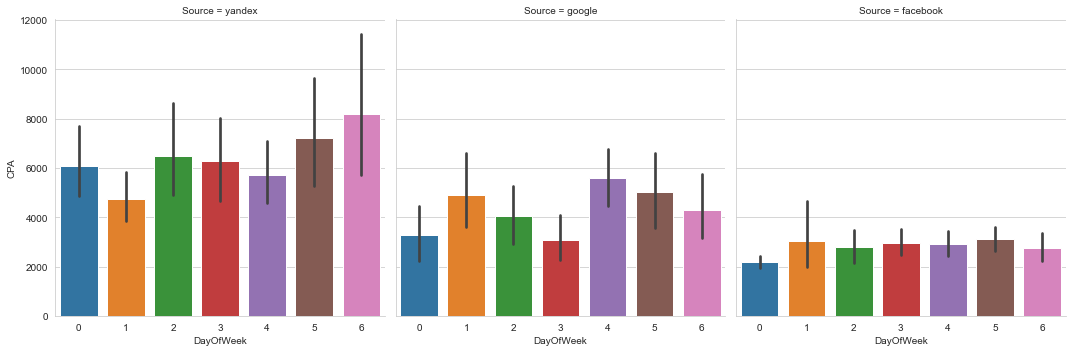

In [27]:
sns.lmplot(x='DayOfWeek', y='CPA', col='Source', data=Sinitza)
sns.catplot(x='DayOfWeek', y='CPA', col='Source', kind='bar', data=Sinitza)

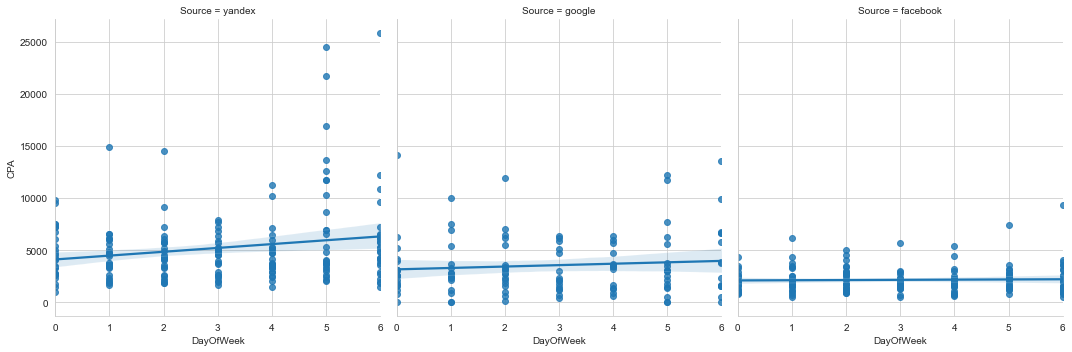

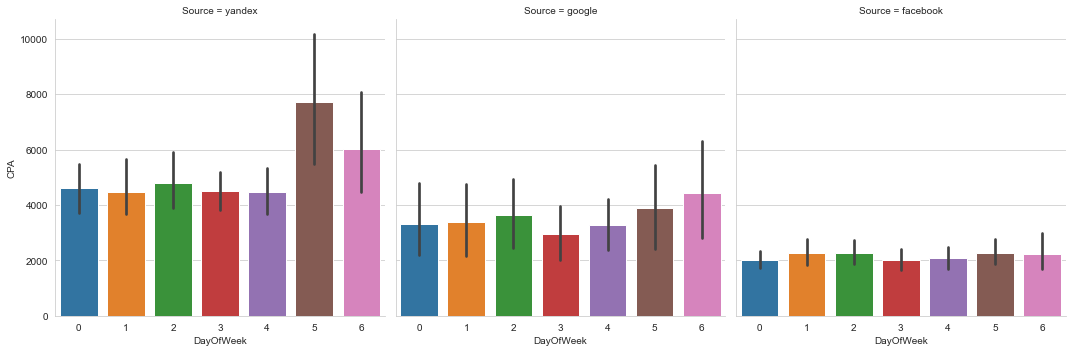

In [28]:
sns.lmplot(x='DayOfWeek', y='CPA', col='Source', data=Lasto4ka)
sns.catplot(x='DayOfWeek', y='CPA', col='Source', kind='bar', data=Lasto4ka)

Посмотрим отдельно по источникам:

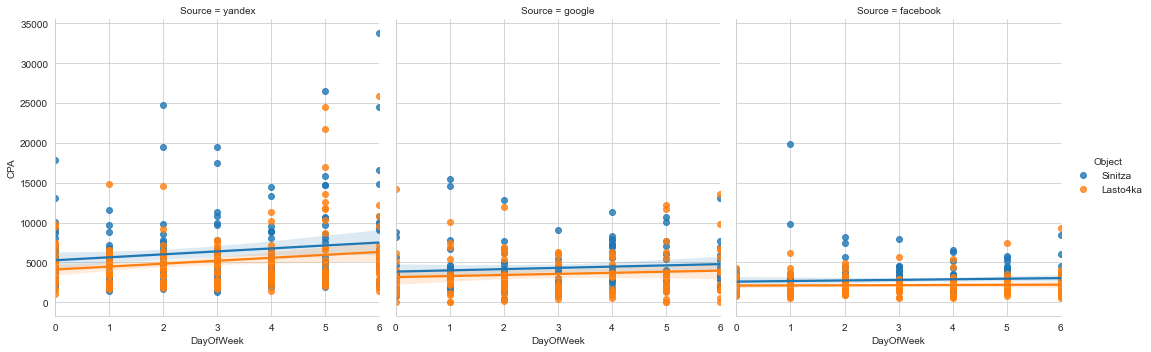

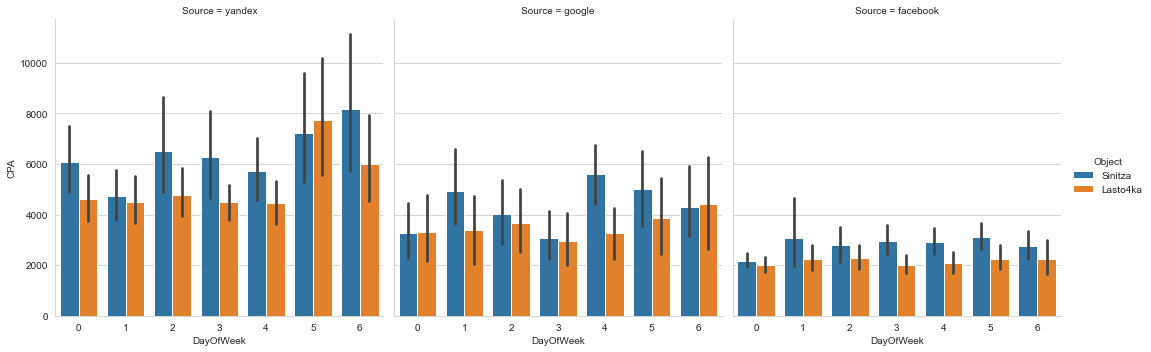

In [29]:
Sinitza['Object'] = 'Sinitza'
Lasto4ka['Object'] = 'Lasto4ka'
Allin = Sinitza.append(Lasto4ka)
sns.lmplot(x='DayOfWeek', y='CPA', col='Source', hue='Object', data=Allin)
sns.catplot(x='DayOfWeek', y='CPA', col='Source', kind='bar', hue='Object', data=Allin)

Ну и взглянем на сами цифры:

In [30]:
SY = Sinitza[(Sinitza['Source'] == 'yandex')]
SFinish = pd.DataFrame(SY.groupby('DayOfWeek')['CPA'].mean()).reset_index()
SG = Sinitza[(Sinitza['Source'] == 'google')]
SG.groupby('DayOfWeek')['CPA'].mean()
SFinish = SFinish.merge(SG.groupby('DayOfWeek')['CPA'].mean(), on='DayOfWeek')
SF = Sinitza[(Sinitza['Source'] == 'facebook')]
SF.groupby('DayOfWeek')['CPA'].mean()
SFinish = SFinish.merge(SF.groupby('DayOfWeek')['CPA'].mean(), on='DayOfWeek')
SFinish.rename(columns={'CPA_x':'Директ', 'CPA_y': 'AdWords', 'CPA': 'Facebook'})

,DayOfWeek,Директ,AdWords,Facebook
0,0,6090.545114,3280.633092,2165.183752
1,1,4742.099362,4916.000819,3054.484532
2,2,6496.908141,4033.822639,2792.048217
3,3,6275.815515,3075.240237,2961.877525
4,4,5725.445313,5587.962611,2921.047818
5,5,7225.484498,5017.288357,3110.114190
6,6,8181.168797,4280.124776,2743.664032


In [31]:
LY = Lasto4ka[(Lasto4ka['Source'] == 'yandex')]
LFinish = pd.DataFrame(LY.groupby('DayOfWeek')['CPA'].mean()).reset_index()
LG = Lasto4ka[(Lasto4ka['Source'] == 'google')]
LG.groupby('DayOfWeek')['CPA'].mean()
LFinish = LFinish.merge(LG.groupby('DayOfWeek')['CPA'].mean(), on='DayOfWeek')
LF = Lasto4ka[(Lasto4ka['Source'] == 'facebook')]
LF.groupby('DayOfWeek')['CPA'].mean()
LFinish = LFinish.merge(LF.groupby('DayOfWeek')['CPA'].mean(), on='DayOfWeek')
LFinish.rename(columns={'CPA_x':'Директ', 'CPA_y': 'AdWords', 'CPA': 'Facebook'})

,DayOfWeek,Директ,AdWords,Facebook
0,0,4594.605604,3312.115074,2017.621403
1,1,4477.202931,3377.227688,2254.774635
2,2,4786.273897,3651.695078,2274.432233
3,3,4495.900346,2967.089080,1996.641050
4,4,4463.728532,3275.218245,2072.410109
5,5,7715.434616,3873.989556,2257.389145
6,6,6010.205429,4413.797133,2246.394010


**Выводы**

Предварительно у меня было 2 гипотезы:
1. CPA в Директе по выходным очень высокая. Связано это с тем, что система очень быстро тратит бюджеты на РСЯ в выходные дни и эффективность этого расхода сомнительная.
2. CPA в Facebook по выходным низкая. Эмпирически казалось, что на выходные приходится бОльшее количество обращений.

На основании приведенных графиков видно:
1. Первая гипотеза подтвердилась. В обоих случаях мы видим рост стоимости обращения в Директе в субботу и воскресенье. 
2. Вторая - нет. Результаты в facebook довольно стабильны и не зависят от дня недели.